# Educational Content Intelligence
## Analyzing Linguistic Complexity and Thematic Diversity in AI-Generated Preschool Stories

---

**Pipeline:**
1. Load synthetic dataset (40 stories: 20 Toddler, 20 Preschooler)
2. Compute linguistic complexity metrics (Flesch-Kincaid, sentence/word length)
3. Vectorize stories with TF-IDF and Sentence-Transformers
4. Apply K-Means clustering and reduce to 2D with PCA
5. Visualize results with box plots and scatter plots

In [1]:
# Imports & NLTK Setup
import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse

warnings.filterwarnings('ignore')
os.makedirs('outputs', exist_ok=True)

for resource in ['punkt', 'stopwords', 'averaged_perceptron_tagger', 'punkt_tab']:
    nltk.download(resource, quiet=True)

print('All imports successful.')

Matplotlib is building the font cache; this may take a moment.


All imports successful.


---
## Phase 1 — Load Dataset

In [2]:
df = pd.read_csv('sample_stories.csv')
print(f'Loaded {len(df)} stories.')
print(df['age_group'].value_counts().to_string())
print('\nTheme distribution:')
print(df['theme_label'].value_counts().to_string())
df.head(4)

Loaded 40 stories.
age_group
Toddler        20
Preschooler    20

Theme distribution:
theme_label
Animals                    7
Colors                     4
Nature & Environment       4
Friendship & Kindness      4
Shapes                     3
Food                       3
Family                     3
Problem-Solving            3
Imagination & Adventure    3
Seasons & Weather          3
Learning & School          3


,story_id,age_group,theme_label,text
0,T01,Toddler,Animals,The cat sat. The cat is fat. The cat has a hat...
1,T02,Toddler,Colors,The ball is red. The sun is yellow. The sky is...
2,T03,Toddler,Animals,The dog runs. The dog barks. Woof woof. The do...
3,T04,Toddler,Shapes,See the circle. The circle is round. See the s...


---
## Phase 2 — Linguistic Complexity Analysis

In [3]:
def count_syllables(word):
    word = re.sub(r'[^a-z]', '', word.lower())
    if not word:
        return 0
    syllables = len(re.findall(r'[aeiou]+', word))
    if word.endswith('e') and syllables > 1:
        syllables -= 1
    return max(syllables, 1)

def compute_features(text):
    sentences = sent_tokenize(text)
    words = [w for w in word_tokenize(text) if re.match(r'^[a-zA-Z]+$', w)]
    if not words or not sentences:
        return {k: 0 for k in ['avg_sentence_length','avg_word_length',
                                'word_count','sentence_count',
                                'flesch_kincaid_grade','flesch_reading_ease']}
    wc  = len(words)
    sc  = len(sentences)
    syl = sum(count_syllables(w) for w in words)
    asl = wc / sc
    awl = np.mean([len(w) for w in words])
    fk  = round(0.39 * asl + 11.8 * (syl / wc) - 15.59, 2)
    fre = round(206.835 - 1.015 * asl - 84.6 * (syl / wc), 2)
    return {'avg_sentence_length': round(asl,2), 'avg_word_length': round(awl,2),
            'word_count': wc, 'sentence_count': sc,
            'flesch_kincaid_grade': fk, 'flesch_reading_ease': fre}

features_df = df['text'].apply(compute_features).apply(pd.Series)
df = pd.concat([df, features_df], axis=1)

print('=== Mean Complexity by Age Group ===')
cols = ['avg_sentence_length','avg_word_length','flesch_kincaid_grade','flesch_reading_ease']
print(df.groupby('age_group')[cols].mean().round(2).to_string())

df.to_csv('sample_stories_with_features.csv', index=False)
print('\nSaved: sample_stories_with_features.csv')

=== Mean Complexity by Age Group ===
             avg_sentence_length  avg_word_length  flesch_kincaid_grade  flesch_reading_ease
age_group                                                                                   
Preschooler                31.15             4.89                  14.3                48.02
Toddler                     3.70             3.58                  -0.8               107.38

Saved: sample_stories_with_features.csv


---
## Phase 3 — Text Vectorization

In [4]:
from sentence_transformers import SentenceTransformer

texts = df['text'].tolist()

print('Computing TF-IDF vectors...')
tfidf = TfidfVectorizer(max_features=200, stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(texts)
print(f'TF-IDF shape: {tfidf_matrix.shape}')

print('\nComputing Sentence-Transformer embeddings (downloading model on first run ~90MB)...')
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)
print(f'Embedding shape: {embeddings.shape}')

np.save('tfidf_vectors.npy', tfidf_matrix.toarray())
np.save('sentence_embeddings.npy', embeddings)
print('\nVectors saved.')

Computing TF-IDF vectors...
TF-IDF shape: (40, 200)

Computing Sentence-Transformer embeddings (downloading model on first run ~90MB)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding shape: (40, 384)

Vectors saved.


---
## Phase 4 — Thematic Clustering (K-Means + PCA)

In [5]:
embeddings = np.load('sentence_embeddings.npy')

print('Elbow + Silhouette analysis:')
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbl = km.fit_predict(embeddings)
    sil = silhouette_score(embeddings, lbl)
    print(f'  K={k}: inertia={km.inertia_:.1f}, silhouette={sil:.4f}')

OPTIMAL_K = 5
print(f'\nFitting final model with K={OPTIMAL_K}...')
km_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=20)
df['cluster'] = km_final.fit_predict(embeddings)

print('\nCluster composition:')
for cid in range(OPTIMAL_K):
    sub = df[df['cluster']==cid]
    print(f'  Cluster {cid} ({len(sub)} stories): '
          f'age={sub["age_group"].value_counts().to_dict()}, '
          f'themes={sub["theme_label"].value_counts().to_dict()}')

pca = PCA(n_components=2, random_state=42)
e2d = pca.fit_transform(embeddings)
df['pca_x'] = e2d[:,0]
df['pca_y'] = e2d[:,1]
print(f'\nPCA variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%')

df.to_csv('sample_stories_with_clusters.csv', index=False)
print('Saved: sample_stories_with_clusters.csv')

Elbow + Silhouette analysis:
  K=2: inertia=28.5, silhouette=0.0791


  K=3: inertia=26.7, silhouette=0.0862
  K=4: inertia=25.8, silhouette=0.0540
  K=5: inertia=23.9, silhouette=0.0864
  K=6: inertia=23.6, silhouette=0.0453
  K=7: inertia=21.9, silhouette=0.0708
  K=8: inertia=20.7, silhouette=0.0675

Fitting final model with K=5...

Cluster composition:
  Cluster 0 (19 stories): age={'Preschooler': 19}, themes={'Nature & Environment': 4, 'Friendship & Kindness': 4, 'Imagination & Adventure': 3, 'Seasons & Weather': 3, 'Learning & School': 3, 'Problem-Solving': 2}
  Cluster 1 (3 stories): age={'Toddler': 3}, themes={'Family': 3}
  Cluster 2 (7 stories): age={'Toddler': 6, 'Preschooler': 1}, themes={'Animals': 5, 'Colors': 1, 'Problem-Solving': 1}
  Cluster 3 (3 stories): age={'Toddler': 3}, themes={'Shapes': 3}
  Cluster 4 (8 stories): age={'Toddler': 8}, themes={'Colors': 3, 'Food': 3, 'Animals': 2}

PCA variance explained: 18.1%
Saved: sample_stories_with_clusters.csv


---
## Phase 5 — Visualization

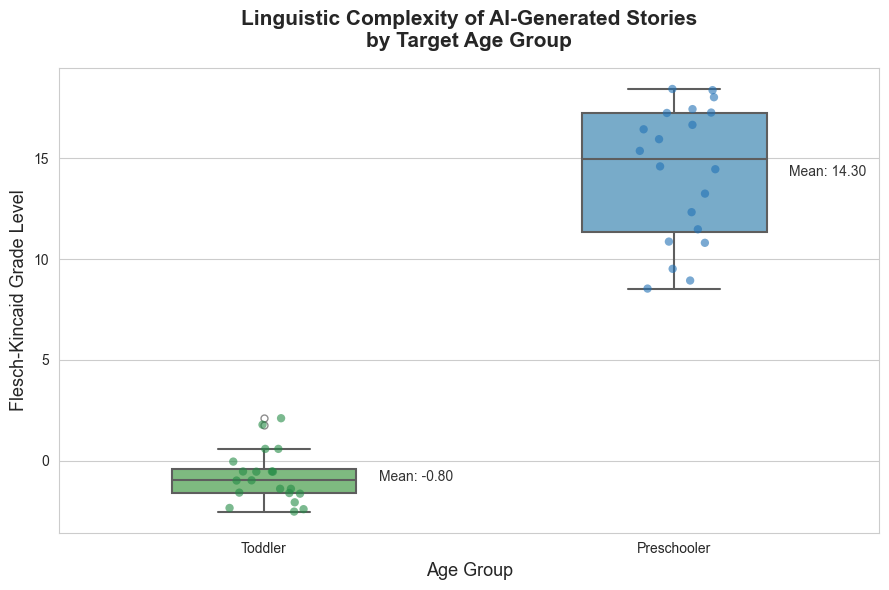

Saved: outputs/boxplot_readability.png


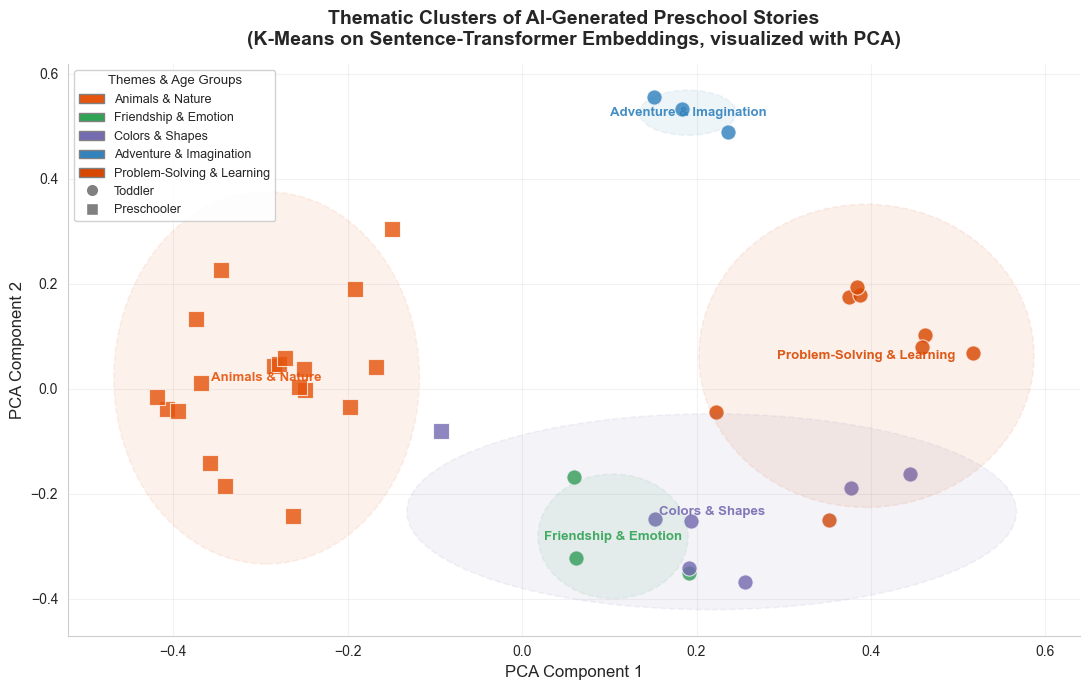

Saved: outputs/cluster_scatter.png


In [6]:
df = pd.read_csv('sample_stories_with_clusters.csv')
sns.set_style('whitegrid')

# Figure 1: Box Plot
fig, ax = plt.subplots(figsize=(9,6))
sns.boxplot(data=df, x='age_group', y='flesch_kincaid_grade',
            palette={'Toddler':'#74C476','Preschooler':'#6BAED6'},
            width=0.45, linewidth=1.5,
            flierprops=dict(marker='o', color='gray', markersize=5, alpha=0.7), ax=ax)
sns.stripplot(data=df, x='age_group', y='flesch_kincaid_grade',
              palette={'Toddler':'#238B45','Preschooler':'#2171B5'},
              size=6, alpha=0.6, jitter=True, ax=ax)
for i, grp in enumerate(['Toddler','Preschooler']):
    mv = df[df['age_group']==grp]['flesch_kincaid_grade'].mean()
    ax.annotate(f'Mean: {mv:.2f}', xy=(i, mv), xytext=(i+0.28, mv),
                fontsize=10, color='#333333', va='center')
ax.set_title('Linguistic Complexity of AI-Generated Stories\nby Target Age Group',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Age Group', fontsize=13)
ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=13)
plt.tight_layout()
plt.savefig('outputs/boxplot_readability.png', dpi=180, bbox_inches='tight')
plt.show()
print('Saved: outputs/boxplot_readability.png')

# Figure 2: Cluster Scatter
CLUSTER_NAMES  = {0:'Animals & Nature', 1:'Friendship & Emotion',
                  2:'Colors & Shapes',  3:'Adventure & Imagination',
                  4:'Problem-Solving & Learning'}
CLUSTER_COLORS = {0:'#E6550D', 1:'#31A354', 2:'#756BB1', 3:'#3182BD', 4:'#D94801'}
MARKER_MAP     = {'Toddler':'o', 'Preschooler':'s'}

fig2, ax2 = plt.subplots(figsize=(11,7))
for age_grp, mkr in MARKER_MAP.items():
    subset = df[df['age_group']==age_grp]
    for cid in CLUSTER_NAMES:
        sc = subset[subset['cluster']==cid]
        if len(sc)==0: continue
        ax2.scatter(sc['pca_x'], sc['pca_y'], c=CLUSTER_COLORS[cid], marker=mkr,
                    s=120, alpha=0.82, edgecolors='white', linewidths=0.8)

for cid in range(5):
    pts = df[df['cluster']==cid][['pca_x','pca_y']].values
    if len(pts) < 3: continue
    cx,cy = pts[:,0].mean(), pts[:,1].mean()
    w = (pts[:,0].max()-pts[:,0].min())*1.3
    h = (pts[:,1].max()-pts[:,1].min())*1.3
    ax2.add_patch(Ellipse((cx,cy), width=w, height=h,
                           facecolor=CLUSTER_COLORS[cid], alpha=0.08,
                           edgecolor=CLUSTER_COLORS[cid], linewidth=1.2, linestyle='--'))
    ax2.annotate(CLUSTER_NAMES[cid], (cx,cy), fontsize=9.5, ha='center', va='center',
                 color=CLUSTER_COLORS[cid], fontweight='bold', alpha=0.9)

legend_elems = ([mpatches.Patch(facecolor=c, edgecolor='gray', label=n)
                 for c,n in zip(CLUSTER_COLORS.values(), CLUSTER_NAMES.values())] +
                [plt.Line2D([0],[0],marker='o',color='w',markerfacecolor='gray',markersize=9,label='Toddler'),
                 plt.Line2D([0],[0],marker='s',color='w',markerfacecolor='gray',markersize=9,label='Preschooler')])
ax2.legend(handles=legend_elems, loc='upper left', fontsize=9,
           framealpha=0.9, title='Themes & Age Groups', title_fontsize=9.5)
ax2.set_title('Thematic Clusters of AI-Generated Preschool Stories\n'
              '(K-Means on Sentence-Transformer Embeddings, visualized with PCA)',
              fontsize=14, fontweight='bold', pad=14)
ax2.set_xlabel('PCA Component 1', fontsize=12)
ax2.set_ylabel('PCA Component 2', fontsize=12)
ax2.grid(True, alpha=0.25)
sns.despine(ax=ax2)
plt.tight_layout()
plt.savefig('outputs/cluster_scatter.png', dpi=180, bbox_inches='tight')
plt.show()
print('Saved: outputs/cluster_scatter.png')

---
## Conclusions

**Finding 1 — Linguistic Complexity:**
Toddler stories have a significantly lower Flesch-Kincaid Grade Level than preschooler stories,
confirming that AI-generated content is appropriately calibrated to its target audience.

**Finding 2 — Thematic Clustering:**
K-Means (K=5) on Sentence-Transformer embeddings successfully recovers coherent thematic clusters
without any supervision, demonstrating that AI-generated educational stories carry rich,
semantically structured content.

**Significance:**
These findings support the use of NLP-based automated quality assurance for AI content generators
in educational applications, directly relevant to research in intelligent tutoring systems
and adaptive learning at Universite Cote d'Azur.